In [57]:
import tszip
import pandas as pd
import numpy as np
import tszip
import sc2ts
import matplotlib_venn
import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
df_sc2ts = pd.read_csv("../data/recombinants.csv").set_index("recombinant")

,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,parent_mrca_pango,parent_mrca_scorpio,parent_mrca_time,parent_mrca_date,is_rebar_recombinant,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts
recombinant,,,,,,,,,,,,,,,,,,,,,
1280342,ERR9939974,1,1,1,695,958,1,COVID-ARTIC-V4.1,.,2022-06-27,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,5,2,16,False,8
663484,SRR20259474,1,1,1,510,1222,1,COVID-AMPLISEQ-V1,.,2021-10-21,...,B.1.617.2,Delta (B.1.617.2-like),794.394486,2020-12-19,False,2,2,16,False,5
1356368,ERR10219711,2,1,1,695,1453,1,COVID-ARTIC-V4.1,.,2022-08-30,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,4,1,16,False,5
1253364,ERR9848224,855,1,1,695,1627,1,COVID-ARTIC-V4.1,.,2022-05-30,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,4,1,54,False,7
1279026,ERR9940192,662,1,1,695,1627,0,COVID-ARTIC-V4.1,.,2022-06-26,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,3,2,8,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375056,SRR21797337,1,1,1,26276,29729,1,COVID-ARTIC-V4.1,.,2022-09-19,...,BA.2,Omicron (BA.2-like),447.000000,2021-12-01,False,2,22,2,False,5
1373412,SRR21794908,2,1,1,28331,29729,2,COVID-ARTIC-V4.1,.,2022-09-17,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,5,25,2,False,7
1418709,ERR10708209,37,12,1,28682,29729,8,COVID-ARTIC-V4.1,4.1alt,2022-12-17,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,8,23,2,False,10


In [2]:
  
def add_x_lineages(df):

    d = {}
    for k, row in df.iterrows():
        d[k] = eval(row["pango_counts"])
    df["pango_counts"] = d
    
    x_lineage_involved = dict()
    for k, row in df.iterrows():
        pango_counts = row["pango_counts"]
        x_lineage_involved[k] = False
        # FIXME this is a very rough first pass, needs to be examined.
        if any(lin.startswith("X") for lin in pango_counts.keys()) and len(pango_counts) < 20:
            x_lineage_involved[k] = True
            if any((lin.startswith("XB") and "." in lin) for lin in pango_counts.keys()):
                # Manually filter out the de-novo XBB ones
                x_lineage_involved[k] = False

    df["x_lineage_involved"] = x_lineage_involved
    return df

dfp3 = pd.read_csv("../arg_postprocessing/sc2ts_viridian_v1.2_ripples_p3.csv")
dfp4 = pd.read_csv("../arg_postprocessing/sc2ts_viridian_v1.2_ripples_p4.csv")

dfp3 = add_x_lineages(dfp3)
dfp4 = add_x_lineages(dfp4)

## Distribution of numbers desdendants

For Ripples p3 and p4, small numbers of descendants dominate, with singletons accounting for over a half in all cases. Ripples p3 has more in all classes, with no one particular set of descendants dominating.

In [81]:

bins = list(range(1, 12)) + [100, 1000, 10000, 100_000, 1_000_000] 
str_bins = [f"{j}" for j in range(1, 11)] + ["10-100", "100-1000", "1000-10k", "10k-100k", "100k-1m"]
df = pd.DataFrame({"bins": bins[:-1], 
                   "Bin": str_bins,
                   "ripples_p3:": np.histogram(dfp3.usher_num_descendants.values, bins=bins)[0],
                   "ripples_p4:": np.histogram(dfp4.usher_num_descendants.values, bins=bins)[0],
                   "sc2ts": np.histogram(df_sc2ts.num_descendant_samples.values, bins=bins)[0]})
df

,bins,Bin,ripples_p3:,ripples_p4:,sc2ts
0,1,1,2616,757,525
1,2,2,575,178,124
2,3,3,232,65,47
3,4,4,124,38,32
4,5,5,74,14,17
5,6,6,65,17,11
6,7,7,48,9,10
7,8,8,37,11,8
8,9,9,22,6,4
9,10,10,21,5,5


In [83]:
df_lf = pd.melt(df, id_vars=["bins", "Bin"], var_name="Method", value_name="Count")

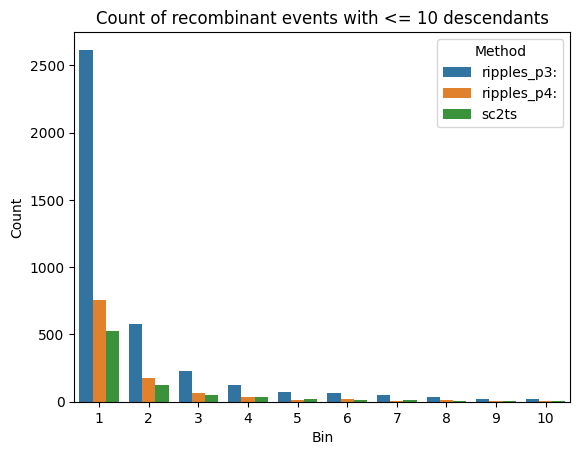

In [92]:
ax = sns.barplot(data=df_lf[df_lf["bins"] < 11], x="Bin", y="Count", hue="Method")
ax.set_title("Count of recombinant events with <= 10 descendants");

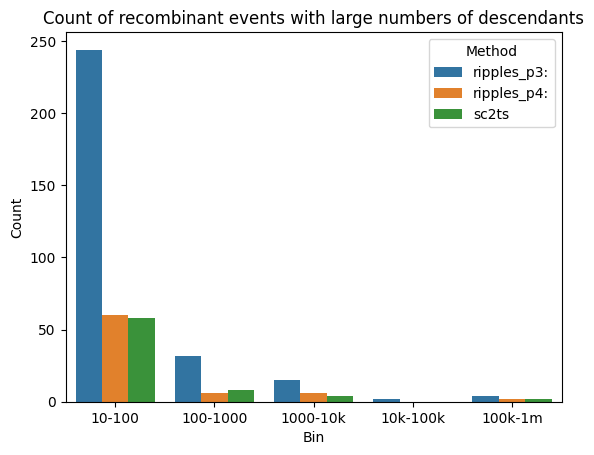

In [91]:
ax = sns.barplot(data=df_lf[df_lf["bins"] >= 11], x="Bin", y="Count", hue="Method");
ax.set_title("Count of recombinant events with large numbers of descendants");

## X lineages

In [3]:
dfp3_x = dfp3[dfp3["x_lineage_involved"]].reset_index()
dfp3_x

,index,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved
0,9,node_600484,{'XBR': 1},1420165,1,1420166,1,1,True
1,178,node_600480,"{'XBD': 30, 'BA.2.75': 5, 'XBR': 1}",1291791,7182,-1,2147483648,36,True
2,451,node_505768,{'XAC': 18},1219046,18,964555,4,18,True
3,545,node_633544,{'XY': 23},1192268,23,1187989,1,23,True
4,571,node_633571,{'XE': 1113},965352,1116,965353,1,1113,True
5,637,node_45191,{'XC': 5},414488,5,414488,0,5,True
6,944,node_633781,{'XL': 64},1034619,64,1034619,0,64,True
7,990,node_633519,"{'XM': 4, 'BA.2': 4}",1093549,8,1003220,1,8,True
8,1057,SRR19708375,{'XAM': 1},1242107,1,1058654,7,1,True
9,1860,node_409296,{'XA': 39},122444,39,122444,0,39,True


In [4]:
dfp4_x = dfp4[dfp4["x_lineage_involved"]].reset_index()
dfp4_x

,index,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved
0,1,node_600484,{'XBR': 1},1420165,1,1420166,1,1,True
1,54,node_600480,"{'BA.2.75': 5, 'XBD': 30, 'XBR': 1}",1291791,7182,-1,2147483648,36,True
2,125,node_505768,{'XAC': 18},1219046,18,964555,4,18,True
3,184,node_45191,{'XC': 5},414488,5,414488,0,5,True
4,281,node_633519,"{'XM': 4, 'BA.2': 4}",1093549,8,1003220,1,8,True
5,531,node_409296,{'XA': 39},122444,39,122444,0,39,True
6,772,node_516786,"{'XAJ': 18, 'BA.4': 1}",974731,45209,-1,2147483648,19,True
7,805,node_6681,"{'XB': 192, 'B.1': 219}",223240,411,-1,2147483648,411,True
8,1009,node_600527,"{'XBM': 10, 'BF.3': 2}",1348822,12,1348822,0,12,True
9,1017,node_505721,{'XS': 17},1000242,17,1000242,0,17,True


In [5]:
dfp4_x[dfp4_x["sc2ts_num_descendants"] != dfp4_x["usher_num_descendants"]]

,index,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved
1,54,node_600480,"{'BA.2.75': 5, 'XBD': 30, 'XBR': 1}",1291791,7182,-1,2147483648,36,True
6,772,node_516786,"{'XAJ': 18, 'BA.4': 1}",974731,45209,-1,2147483648,19,True
10,1034,node_600488,"{'BA.2.75': 5, 'XBD': 30}",1291791,7182,-1,2147483648,35,True


In [6]:
dfp3_x[dfp3_x["sc2ts_num_descendants"] != dfp3_x["usher_num_descendants"]]

,index,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved
1,178,node_600480,"{'XBD': 30, 'BA.2.75': 5, 'XBR': 1}",1291791,7182,-1,2147483648,36,True
4,571,node_633571,{'XE': 1113},965352,1116,965353,1,1113,True
12,2559,node_505720,"{'BA.1': 1, 'BA.1.15': 1, 'XS': 17, 'BA.1.1': 1}",220185,1061795,-1,2147483648,20,True
13,2755,node_516786,"{'XAJ': 18, 'BA.4': 1}",974731,45209,-1,2147483648,19,True
16,3285,node_633486,"{'XE': 1113, 'BA.2': 82, 'XH': 2, 'XJ': 68, 'X...",791357,341822,-1,2147483648,1321,True
19,3646,node_600488,"{'XBD': 30, 'BA.2.75': 5}",1291791,7182,-1,2147483648,35,True


# Singletons

There are 2505 singletons that both sc2ts and Usher agree on (this just means that sc2ts doesn't think these are internal samples). Of  these 425 of the Ripples events are close to 421 sc2ts recombinants, with a 1-1 mapping for 408. 

Of these, 388 are also sc2ts singleton recombinants.


In [96]:
df_singletons = dfp3[(dfp3["sc2ts_num_descendants"] == 1) & (dfp3["usher_num_descendants"]== 1)]
df_singletons

,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved
0,node_141279,{'AY.4': 1},740727,1,-1,2147483648,1,False
1,ERR4989513,{'AD.2': 1},64819,1,-1,2147483648,1,False
2,SRR21610934,{'BA.5.2': 1},1360126,1,1189192,6,1,False
3,SRR18781949,{'BA.1.1': 1},1109101,1,-1,2147483648,1,False
6,node_181333,{'AY.39': 1},391701,1,-1,2147483648,1,False
...,...,...,...,...,...,...,...,...
4103,ERR9380129,{'BA.2': 1},1145941,1,1145942,1,1,False
4104,ERR9407660,{'BD.1': 1},1151135,1,-1,2147483648,1,False
4106,ERR7648958,{'AY.4': 1},830424,1,-1,2147483648,1,False
4107,ERR10627148,{'BN.1.3': 1},1405537,1,-1,2147483648,1,False


In [97]:
tmp = df_singletons[df_singletons["sc2ts_closest_recombinant_path_len"] < 3]
tmp

,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved
9,node_600484,{'XBR': 1},1420165,1,1420166,1,1,True
16,ERR6758858,{'AY.4': 1},478619,1,478620,1,1,False
17,ERR7310305,{'AY.4': 1},707305,1,707306,1,1,False
37,SRR20258232,{'AY.39.1': 1},652406,1,652407,1,1,False
46,node_181897,{'AY.100': 1},894830,1,894831,1,1,False
...,...,...,...,...,...,...,...,...
4061,ERR7310438,{'AY.4': 1},680515,1,680516,1,1,False
4065,node_180710,{'AY.4': 1},586963,1,586964,1,1,False
4067,ERR10306440,{'BA.4': 1},1376014,1,1376015,1,1,False
4080,node_507989,{'BA.2.12.1': 1},1251637,1,1251638,1,1,False


In [101]:
recombinants = tmp["sc2ts_closest_recombinant"].unique()
recombinants.shape

(421,)

In [99]:
tmp["sc2ts_closest_recombinant_path_len"].value_counts()

sc2ts_closest_recombinant_path_len
1    408
2     17
Name: count, dtype: int64

In [104]:
df_ripples_singletons = df_sc2ts.loc[recombinants];
df_ripples_singletons["num_descendant_samples"].value_counts()

num_descendant_samples
1       388
2        15
3         5
8         2
4         1
20        1
6         1
2458      1
96        1
85        1
253       1
22        1
23        1
14        1
241       1
Name: count, dtype: int64




## Non singletons

In [11]:
df_non_singletons = dfp3[(dfp3["usher_num_descendants"] > 1)]
df_non_singletons

,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved
4,node_181294,{'AY.39': 2},558354,2,-1,2147483648,2,False
5,node_627090,"{'CM.7': 1, 'CM.2': 72, 'BA.2.3.20': 79, 'CM.4...",1373997,216,-1,2147483648,216,False
8,node_391741,{'B.1.1.7': 7},106919,7,-1,2147483648,7,False
11,node_95072,{'AY.4.2': 4},750603,4,-1,2147483648,4,False
13,node_181040,{'AY.4': 2},378676,282,-1,2147483648,2,False
...,...,...,...,...,...,...,...,...
4099,node_257005,{'AY.103': 2},510607,2,-1,2147483648,2,False
4100,node_408868,{'B.1.1.7': 39},45987,9780,-1,2147483648,39,False
4105,node_274647,{'AY.25': 3},513122,3,513122,0,3,False
4108,node_178105,{'AY.100': 2},884003,2,-1,2147483648,2,False


In [12]:
df_non_singletons[df_non_singletons["usher_num_descendants"] == df_non_singletons["sc2ts_num_descendants"]]

,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved
4,node_181294,{'AY.39': 2},558354,2,-1,2147483648,2,False
5,node_627090,"{'CM.7': 1, 'CM.2': 72, 'BA.2.3.20': 79, 'CM.4...",1373997,216,-1,2147483648,216,False
8,node_391741,{'B.1.1.7': 7},106919,7,-1,2147483648,7,False
11,node_95072,{'AY.4.2': 4},750603,4,-1,2147483648,4,False
15,node_73616,{'AY.4': 7},759802,7,-1,2147483648,7,False
...,...,...,...,...,...,...,...,...
4077,node_246559,{'AY.103': 2},541670,2,-1,2147483648,2,False
4079,node_622435,{'BA.2.1': 4},1130239,4,-1,2147483648,4,False
4099,node_257005,{'AY.103': 2},510607,2,-1,2147483648,2,False
4105,node_274647,{'AY.25': 3},513122,3,513122,0,3,False


In [13]:
diffs = dfp3["sc2ts_num_descendants"] - dfp3["usher_num_descendants"]
diffs.value_counts()

0         3604
1          147
2           43
3           24
4           19
          ... 
50           1
189614       1
1794         1
708284       1
9741         1
Name: count, Length: 201, dtype: int64

Clade agreement = 3757 91.4%
Non recombinant = 68.2%
Close to recombinant = 16.8%
Passing filter =  632
Total ripples = 4111
Total sc2ts =  855


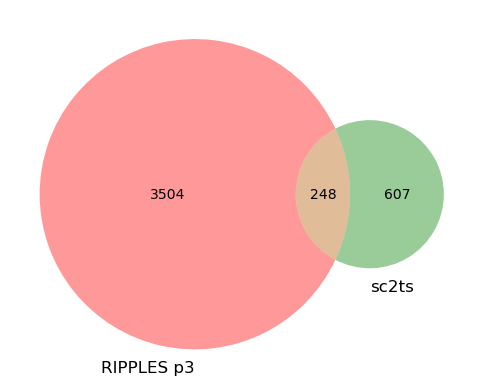

In [14]:
def get_sc2ts_recombinants(df, clade_agreement_threshold=1, closeness=1):
    diffs = df["sc2ts_num_descendants"] - df["usher_num_descendants"]
    clade_agreement = diffs <= clade_agreement_threshold
    print(f"Clade agreement = {clade_agreement.sum()} {clade_agreement.sum() / df.shape[0]:.1%}")
    df = df[clade_agreement]
    close_to_recombinant = df["sc2ts_closest_recombinant_path_len"] <= closeness
    not_recombinant = df["sc2ts_closest_recombinant"] == -1
    print(f"Non recombinant = {not_recombinant.sum() / df.shape[0]:.1%}")
    print(f"Close to recombinant = {close_to_recombinant.sum() / df.shape[0]:.1%}")
    df = df[close_to_recombinant]
    print("Passing filter = ", df.shape[0])
    #print(df["sc2ts_closest_recombinant"].value_counts())
    sc2ts_recombs = df["sc2ts_closest_recombinant"].unique()
    return sc2ts_recombs
    
def draw_venn(df, label, sc2ts_recombs):
    total_ripples = df.shape[0]
    total_sc2ts = 855
    shared = sc2ts_recombs.shape[0]
    print("Total ripples =", total_ripples)
    print("Total sc2ts = ", total_sc2ts)
    matplotlib_venn.venn2([total_ripples - shared, shared, total_sc2ts - shared], [f"RIPPLES {label}", "sc2ts"]);

sc2ts_recombs_p3 = get_sc2ts_recombinants(dfp3, closeness=2)
draw_venn(dfp3, "p3", sc2ts_recombs_p3)

## FIXME

This can't be right - how can we have substantially fewer matching recombination events when we have more events? This needs to be fixed.

Clade agreement = 1052 89.6%
Non recombinant = 41.2%
Close to recombinant = 44.5%
Passing filter =  468
Total ripples = 1174
Total sc2ts =  855


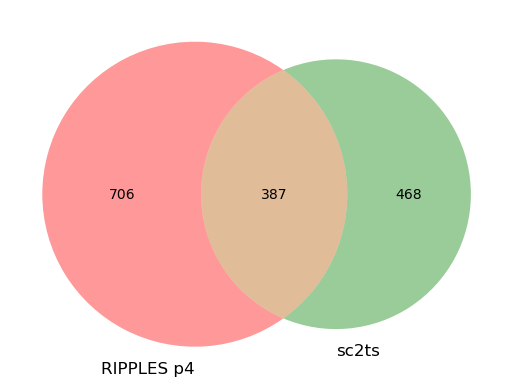

In [15]:
sc2ts_recombs_p4 = get_sc2ts_recombinants(dfp4)
draw_venn(dfp4, "p4", sc2ts_recombs_p4)

In [16]:
dfr = pd.read_csv("../data/recombinants.csv").set_index("recombinant")
dfr

,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,parent_mrca_pango,parent_mrca_scorpio,parent_mrca_time,parent_mrca_date,is_rebar_recombinant,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts
recombinant,,,,,,,,,,,,,,,,,,,,,
1280342,ERR9939974,1,1,1,695,958,1,COVID-ARTIC-V4.1,.,2022-06-27,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,5,2,16,False,8
663484,SRR20259474,1,1,1,510,1222,1,COVID-AMPLISEQ-V1,.,2021-10-21,...,B.1.617.2,Delta (B.1.617.2-like),794.394486,2020-12-19,False,2,2,16,False,5
1356368,ERR10219711,2,1,1,695,1453,1,COVID-ARTIC-V4.1,.,2022-08-30,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,4,1,16,False,5
1253364,ERR9848224,855,1,1,695,1627,1,COVID-ARTIC-V4.1,.,2022-05-30,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,4,1,54,False,7
1279026,ERR9940192,662,1,1,695,1627,0,COVID-ARTIC-V4.1,.,2022-06-26,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,3,2,8,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375056,SRR21797337,1,1,1,26276,29729,1,COVID-ARTIC-V4.1,.,2022-09-19,...,BA.2,Omicron (BA.2-like),447.000000,2021-12-01,False,2,22,2,False,5
1373412,SRR21794908,2,1,1,28331,29729,2,COVID-ARTIC-V4.1,.,2022-09-17,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,5,25,2,False,7
1418709,ERR10708209,37,12,1,28682,29729,8,COVID-ARTIC-V4.1,4.1alt,2022-12-17,...,B.1.1.529,Probable Omicron (Unassigned),970.041636,2020-06-26,False,8,23,2,False,10


In [17]:
dfr["ripples_p4"] = {k: k in sc2ts_recombs_p4 for k in dfr.index}
dfr["ripples_p3"] = {k: k in sc2ts_recombs_p3 for k in dfr.index}
dfr

,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,parent_mrca_time,parent_mrca_date,is_rebar_recombinant,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts,ripples_p4,ripples_p3
recombinant,,,,,,,,,,,,,,,,,,,,,
1280342,ERR9939974,1,1,1,695,958,1,COVID-ARTIC-V4.1,.,2022-06-27,...,970.041636,2020-06-26,False,5,2,16,False,8,False,False
663484,SRR20259474,1,1,1,510,1222,1,COVID-AMPLISEQ-V1,.,2021-10-21,...,794.394486,2020-12-19,False,2,2,16,False,5,False,True
1356368,ERR10219711,2,1,1,695,1453,1,COVID-ARTIC-V4.1,.,2022-08-30,...,970.041636,2020-06-26,False,4,1,16,False,5,False,False
1253364,ERR9848224,855,1,1,695,1627,1,COVID-ARTIC-V4.1,.,2022-05-30,...,970.041636,2020-06-26,False,4,1,54,False,7,False,False
1279026,ERR9940192,662,1,1,695,1627,0,COVID-ARTIC-V4.1,.,2022-06-26,...,970.041636,2020-06-26,False,3,2,8,False,6,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375056,SRR21797337,1,1,1,26276,29729,1,COVID-ARTIC-V4.1,.,2022-09-19,...,447.000000,2021-12-01,False,2,22,2,False,5,True,True
1373412,SRR21794908,2,1,1,28331,29729,2,COVID-ARTIC-V4.1,.,2022-09-17,...,970.041636,2020-06-26,False,5,25,2,False,7,True,True
1418709,ERR10708209,37,12,1,28682,29729,8,COVID-ARTIC-V4.1,4.1alt,2022-12-17,...,970.041636,2020-06-26,False,8,23,2,False,10,True,True


In [18]:
pango_x_events = pd.read_csv("../data/pango_x_events.csv").set_index("root")
mapping = pango_x_events["pango"].to_dict()
dfr["event_label"] = {k: mapping.get(k, "novel") for k in dfr.index}
dfr


,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,parent_mrca_date,is_rebar_recombinant,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts,ripples_p4,ripples_p3,event_label
recombinant,,,,,,,,,,,,,,,,,,,,,
1280342,ERR9939974,1,1,1,695,958,1,COVID-ARTIC-V4.1,.,2022-06-27,...,2020-06-26,False,5,2,16,False,8,False,False,novel
663484,SRR20259474,1,1,1,510,1222,1,COVID-AMPLISEQ-V1,.,2021-10-21,...,2020-12-19,False,2,2,16,False,5,False,True,novel
1356368,ERR10219711,2,1,1,695,1453,1,COVID-ARTIC-V4.1,.,2022-08-30,...,2020-06-26,False,4,1,16,False,5,False,False,novel
1253364,ERR9848224,855,1,1,695,1627,1,COVID-ARTIC-V4.1,.,2022-05-30,...,2020-06-26,False,4,1,54,False,7,False,False,novel
1279026,ERR9940192,662,1,1,695,1627,0,COVID-ARTIC-V4.1,.,2022-06-26,...,2020-06-26,False,3,2,8,False,6,False,False,novel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375056,SRR21797337,1,1,1,26276,29729,1,COVID-ARTIC-V4.1,.,2022-09-19,...,2021-12-01,False,2,22,2,False,5,True,True,novel
1373412,SRR21794908,2,1,1,28331,29729,2,COVID-ARTIC-V4.1,.,2022-09-17,...,2020-06-26,False,5,25,2,False,7,True,True,novel
1418709,ERR10708209,37,12,1,28682,29729,8,COVID-ARTIC-V4.1,4.1alt,2022-12-17,...,2020-06-26,False,8,23,2,False,10,True,True,novel


In [19]:
dfr[~dfr["ripples_p3"]]["net_min_supporting_loci_lft_rgt_ge_4"].value_counts()

net_min_supporting_loci_lft_rgt_ge_4
False    176
True      72
Name: count, dtype: int64

In [23]:
df_missing_hq = dfr[(~dfr["ripples_p3"]) & (dfr["net_min_supporting_loci_lft_rgt_ge_4"])]
df_missing_hq

,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,parent_mrca_date,is_rebar_recombinant,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts,ripples_p4,ripples_p3,event_label
recombinant,,,,,,,,,,,,,,,,,,,,,
995727,ERR8495032,5,1,1,4185,4321,0,COVID-ARTIC-V4.1,4.1alt,2022-01-27,...,2020-06-26,True,3,6,44,True,6,False,False,novel
1058654,ERR8691075,154,1,1,4322,5386,0,COVID-ARTIC-V4.1,4.1alt,2022-02-12,...,2020-06-26,True,5,8,43,True,7,False,False,XQ
1057278,SRR20392523,1,1,1,5585,6040,2,COVID-ARTIC-V4.1,.,2022-02-11,...,2020-01-28,True,7,8,82,True,8,False,False,novel
946761,ERR8076129,16,1,1,5387,6402,1,COVID-ARTIC-V4.1,4.1alt,2022-01-13,...,2020-01-28,True,6,6,74,True,6,False,False,XF
369130,ERR6457057,1,1,1,5585,6402,1,COVID-ARTIC-V3,3,2021-07-29,...,2020-07-27,True,4,6,26,True,6,False,False,novel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341416,SRR21382433,1,1,1,27039,27259,2,COVID-ARTIC-V4.1,.,2022-08-15,...,2022-03-01,True,5,5,4,True,7,False,False,novel
1411996,ERR10666854,1,1,1,23278,27438,2,COVID-ARTIC-V4.1,4.1alt,2022-11-29,...,2022-03-01,True,7,9,6,True,6,False,False,novel
1385832,SRR21909427,2,1,1,27439,27998,0,COVID-ARTIC-V4.1,.,2022-10-03,...,2022-03-01,False,5,12,5,True,5,False,False,novel


In [24]:
df_missing_hq[df_missing_hq["event_label"] != "novel"].sort_values("num_descendant_samples")[["event_label", "num_descendant_samples"]]

,event_label,num_descendant_samples
recombinant,,
1158127,XM,1
938900,XM,1
1083412,XG,3
1379419,XBH,6
946761,XF,16
1291970,XBG,25
1378208,XBD,30
1058654,XQ,154


,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,parent_mrca_date,is_rebar_recombinant,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts,ripples_p4,ripples_p3,event_label
recombinant,,,,,,,,,,,,,,,,,,,,,
1158127,ERR9447529,1,1,1,21847,22194,0,COVID-ARTIC-V4.1,4.1alt,2022-03-19,...,2020-06-26,True,3,27,17,True,4,False,False,XM
938900,SRR19024311,1,1,1,22205,22673,0,COVID-ARTIC-V4.1,.,2022-01-09,...,2020-06-26,True,3,26,14,True,27,False,False,XM
1083412,ERR9089519,3,1,1,5925,6513,3,COVID-ARTIC-V4.1,4.1alt,2022-02-19,...,2020-06-26,True,3,9,38,True,7,False,False,XG
1379419,ERR10381145,6,1,1,15452,22001,0,COVID-ARTIC-V4.1,4.1alt,2022-09-24,...,2021-11-11,True,3,6,14,True,6,False,False,XBH
946761,ERR8076129,16,1,1,5387,6402,1,COVID-ARTIC-V4.1,4.1alt,2022-01-13,...,2020-01-28,True,6,6,74,True,6,False,False,XF
1187989,SRR20520593,23,1,1,11538,12880,3,COVID-ARTIC-V4.1,.,2022-04-01,...,2020-06-26,True,3,22,31,True,8,False,True,XY
1291970,ERR10000477,25,1,1,22305,22917,2,COVID-ARTIC-V4.1,4.1alt,2022-07-06,...,2021-11-11,True,4,11,15,True,10,False,False,XBG
1378208,SRR21898564,30,1,1,23020,24620,0,COVID-ARTIC-V4.1,.,2022-09-22,...,2021-11-11,True,6,23,12,True,7,False,False,XBD
1159411,ERR9444530,32,1,1,2833,4321,1,COVID-ARTIC-V4.1,4.1alt,2022-03-20,...,2020-06-26,True,4,5,48,True,5,False,True,XW
